## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -1.252423     584.398073   -21.601480     -26.402849   
1            2     -1.252423     584.398073   -21.601480     -26.402849   
2            3     -1.252423     584.398073   -21.601480     -26.402849   
3            4     -1.252423     584.398073   -21.601480     -26.402849   
4            5     -1.252423     584.398073   -21.601480     -26.402849   
...        ...           ...            ...          ...            ...   
1752345     46     -3.068643     528.790330   -15.910644     -20.374967   
1752346     47     -3.068643     528.790330   -15.910644     -20.374967   
1752347     48     -3.068643     528.790330   -15.910644     -20.374967   
1752348     49     -3.068643     528.790330   -15.910644     -20.374967   
1752349     50     -3.068643     528.790330   -15.910644     -20.374967   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 35047
Number of training points: 1051400


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns = ['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day',  'ice', 'snow', 'snowice','diffusivity', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',
                   'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1051400, 45)
(700950, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 1.0741378
RMSE of after m1 1.0786695
RMSE of after m3 1.0407596
RMSE of after m4 1.0396031
RMSE of after m0 1.1212374
RMSE of after m1 1.1282916
RMSE of after m3 1.0478444
RMSE of after m4 1.0466539
RMSE of after m0 1.0410389
RMSE of after m1 1.0453647
RMSE of after m3 1.02929
RMSE of after m4 1.0293282
RMSE of after m0 0.97189283
RMSE of after m1 0.9162552
RMSE of after m3 0.9118413
RMSE of after m4 0.91021544
RMSE of after m0 0.97167057
RMSE of after m1 0.8546222
RMSE of after m3 0.80167675
RMSE of after m4 0.79749966
RMSE of after m0 0.9793272
RMSE of after m1 0.85550714
RMSE of after m3 0.8063246
RMSE of after m4 0.80170536
RMSE of after m0 0.981682
RMSE of after m1 0.8496642
RMSE of after m3 0.80814856
RMSE of after m4 0.80385697
RMSE of after m0 0.98019946
RMSE of after m1 0.84566945
RMSE of after m3 0.8049863
RMSE of after m4 0.80070895
RMSE of after m0 0.9808747
RMSE of after m1 0.8489029
RMSE of after m3 0.82143307
RMSE of after m4 0.8168518
RMSE of after m0 0

RMSE of after m1 0.91666627
RMSE of after m3 0.6875363
RMSE of after m4 0.6839527
RMSE of after m0 1.1266804
RMSE of after m1 0.8978812
RMSE of after m3 0.70543426
RMSE of after m4 0.70395935
RMSE of after m0 1.1228943
RMSE of after m1 0.8966167
RMSE of after m3 0.67081743
RMSE of after m4 0.6704053
RMSE of after m0 1.2154654
RMSE of after m1 0.91917336
RMSE of after m3 0.6226417
RMSE of after m4 0.6205993
RMSE of after m0 1.1893656
RMSE of after m1 0.8985243
RMSE of after m3 0.6855428
RMSE of after m4 0.6828911
RMSE of after m0 1.1408919
RMSE of after m1 0.87766266
RMSE of after m3 0.7440469
RMSE of after m4 0.74066424
RMSE of after m0 1.1666178
RMSE of after m1 0.90803534
RMSE of after m3 0.6944533
RMSE of after m4 0.69080204
RMSE of after m0 1.1474738
RMSE of after m1 0.88394904
RMSE of after m3 0.73727965
RMSE of after m4 0.7336196
RMSE of after m0 1.1590643
RMSE of after m1 0.8834053
RMSE of after m3 0.7464731
RMSE of after m4 0.7438412
RMSE of after m0 1.1656383
RMSE of after m1 

RMSE of after m1 0.87944263
RMSE of after m3 0.8680941
RMSE of after m4 0.86276776
RMSE of after m0 0.89146024
RMSE of after m1 0.89297944
RMSE of after m3 0.894841
RMSE of after m4 0.88985825
RMSE of after m0 0.8341228
RMSE of after m1 0.8353958
RMSE of after m3 0.83060056
RMSE of after m4 0.82561374
RMSE of after m0 0.824183
RMSE of after m1 0.8254507
RMSE of after m3 0.8134573
RMSE of after m4 0.8082634
RMSE of after m0 0.80726606
RMSE of after m1 0.8083386
RMSE of after m3 0.80643487
RMSE of after m4 0.8021137
RMSE of after m0 0.84367114
RMSE of after m1 0.8448155
RMSE of after m3 0.84464014
RMSE of after m4 0.8394837
RMSE of after m0 0.86771524
RMSE of after m1 0.86862266
RMSE of after m3 0.8664223
RMSE of after m4 0.8611865
RMSE of after m0 0.8741031
RMSE of after m1 0.8748102
RMSE of after m3 0.87462574
RMSE of after m4 0.8708359
RMSE of after m0 0.9269132
RMSE of after m1 0.927762
RMSE of after m3 0.9240997
RMSE of after m4 0.920228
RMSE of after m0 0.91765916
RMSE of after m1 

RMSE of after m1 0.85477597
RMSE of after m3 0.8505519
RMSE of after m4 0.8463132
RMSE of after m0 0.87497866
RMSE of after m1 0.87485975
RMSE of after m3 0.87435406
RMSE of after m4 0.8702391
RMSE of after m0 0.83587456
RMSE of after m1 0.8358882
RMSE of after m3 0.831384
RMSE of after m4 0.8270565
RMSE of after m0 0.8209751
RMSE of after m1 0.82106346
RMSE of after m3 0.8128836
RMSE of after m4 0.8085776
RMSE of after m0 0.8341643
RMSE of after m1 0.834362
RMSE of after m3 0.8310164
RMSE of after m4 0.82620007
RMSE of after m0 0.8154071
RMSE of after m1 0.81560427
RMSE of after m3 0.8154067
RMSE of after m4 0.8112509
RMSE of after m0 0.84760374
RMSE of after m1 0.84752494
RMSE of after m3 0.8470582
RMSE of after m4 0.8427882
RMSE of after m0 0.86056983
RMSE of after m1 0.86029315
RMSE of after m3 0.8550065
RMSE of after m4 0.8508694
RMSE of after m0 0.88453484
RMSE of after m1 0.88436973
RMSE of after m3 0.8748706
RMSE of after m4 0.87070817
RMSE of after m0 0.9006455
RMSE of after m

RMSE of after m3 0.8828825
RMSE of after m4 0.8770531
RMSE of after m0 0.8614159
RMSE of after m1 0.86257523
RMSE of after m3 0.8592704
RMSE of after m4 0.8540946
RMSE of after m0 0.844573
RMSE of after m1 0.8455741
RMSE of after m3 0.8419893
RMSE of after m4 0.83819973
RMSE of after m0 0.8723043
RMSE of after m1 0.8736202
RMSE of after m3 0.8662401
RMSE of after m4 0.8643383
RMSE of after m0 0.8977181
RMSE of after m1 0.8987223
RMSE of after m3 0.8916985
RMSE of after m4 0.8910471
RMSE of after m0 0.9123038
RMSE of after m1 0.91310596
RMSE of after m3 0.9046208
RMSE of after m4 0.9043547
RMSE of after m0 0.8285039
RMSE of after m1 0.82994527
RMSE of after m3 0.82002056
RMSE of after m4 0.8174853
RMSE of after m0 0.81312865
RMSE of after m1 0.8152288
RMSE of after m3 0.80928034
RMSE of after m4 0.80666965
RMSE of after m0 0.8204968
RMSE of after m1 0.82283324
RMSE of after m3 0.81754273
RMSE of after m4 0.81176305
RMSE of after m0 0.8140814
RMSE of after m1 0.8162141
RMSE of after m3 0

RMSE of after m1 0.9836654
RMSE of after m3 0.6828318
RMSE of after m4 0.6922583
RMSE of after m0 1.2974486
RMSE of after m1 0.9270627
RMSE of after m3 0.7296406
RMSE of after m4 0.7390502
RMSE of after m0 1.296639
RMSE of after m1 0.9396614
RMSE of after m3 0.6380922
RMSE of after m4 0.6472052
RMSE of after m0 1.1980102
RMSE of after m1 0.89096534
RMSE of after m3 0.61090326
RMSE of after m4 0.61940145
RMSE of after m0 1.1871971
RMSE of after m1 0.8912341
RMSE of after m3 0.683683
RMSE of after m4 0.69208145
RMSE of after m0 1.180202
RMSE of after m1 0.8999883
RMSE of after m3 0.726521
RMSE of after m4 0.7356144
RMSE of after m0 1.1816853
RMSE of after m1 0.9007297
RMSE of after m3 0.7441516
RMSE of after m4 0.7547917
RMSE of after m0 1.1793253
RMSE of after m1 0.8946309
RMSE of after m3 0.710795
RMSE of after m4 0.72063285
RMSE of after m0 1.1822512
RMSE of after m1 0.89396256
RMSE of after m3 0.71217865
RMSE of after m4 0.72153765
RMSE of after m0 1.1682432
RMSE of after m1 0.887928

RMSE of after m1 0.9467211
RMSE of after m3 0.67561597
RMSE of after m4 0.6720685
RMSE of after m0 1.2740849
RMSE of after m1 0.945788
RMSE of after m3 0.6745893
RMSE of after m4 0.6701316
RMSE of after m0 1.2176253
RMSE of after m1 0.9310382
RMSE of after m3 0.7140779
RMSE of after m4 0.7086095
RMSE of after m0 1.2902576
RMSE of after m1 0.9739623
RMSE of after m3 0.6453702
RMSE of after m4 0.6376707
RMSE of after m0 1.3243276
RMSE of after m1 0.9814549
RMSE of after m3 0.5909079
RMSE of after m4 0.5825521
RMSE of after m0 1.3364446
RMSE of after m1 0.97572255
RMSE of after m3 0.64517134
RMSE of after m4 0.6365416
RMSE of after m0 1.3341267
RMSE of after m1 0.9764835
RMSE of after m3 0.6421765
RMSE of after m4 0.636773
RMSE of after m0 1.3589399
RMSE of after m1 0.9875048
RMSE of after m3 0.65407866
RMSE of after m4 0.64751685
RMSE of after m0 1.291579
RMSE of after m1 0.9663445
RMSE of after m3 0.6493767
RMSE of after m4 0.64234275
RMSE of after m0 1.3061781
RMSE of after m1 0.974132

RMSE of after m3 0.73380816
RMSE of after m4 0.72575665
RMSE of after m0 1.0607979
RMSE of after m1 0.86028
RMSE of after m3 0.7502955
RMSE of after m4 0.7426043
RMSE of after m0 1.0619032
RMSE of after m1 0.8807343
RMSE of after m3 0.7711576
RMSE of after m4 0.76302296
RMSE of after m0 1.0441417
RMSE of after m1 0.8491513
RMSE of after m3 0.72613955
RMSE of after m4 0.7171741
RMSE of after m0 1.0633812
RMSE of after m1 0.8622855
RMSE of after m3 0.750453
RMSE of after m4 0.74014723
RMSE of after m0 1.0595073
RMSE of after m1 0.8687153
RMSE of after m3 0.7732142
RMSE of after m4 0.76248586
RMSE of after m0 1.0588706
RMSE of after m1 0.87993383
RMSE of after m3 0.79141325
RMSE of after m4 0.780552
RMSE of after m0 0.99421203
RMSE of after m1 0.8382662
RMSE of after m3 0.73020065
RMSE of after m4 0.72051585
RMSE of after m0 0.98064953
RMSE of after m1 0.8373325
RMSE of after m3 0.7419104
RMSE of after m4 0.7308009
RMSE of after m0 0.9851003
RMSE of after m1 0.9384806
RMSE of after m3 0.9

RMSE of after m1 0.79707754
RMSE of after m3 0.7908221
RMSE of after m4 0.78549105
RMSE of after m0 0.7483457
RMSE of after m1 0.7491026
RMSE of after m3 0.74338007
RMSE of after m4 0.7375805
RMSE of after m0 0.6984063
RMSE of after m1 0.6985502
RMSE of after m3 0.69475526
RMSE of after m4 0.689069
RMSE of after m0 0.73251116
RMSE of after m1 0.7328003
RMSE of after m3 0.7295221
RMSE of after m4 0.7235199
RMSE of after m0 0.75830257
RMSE of after m1 0.7586974
RMSE of after m3 0.7545981
RMSE of after m4 0.7487107
RMSE of after m0 0.73740846
RMSE of after m1 0.73791844
RMSE of after m3 0.734128
RMSE of after m4 0.72855675
RMSE of after m0 0.7154262
RMSE of after m1 0.7159926
RMSE of after m3 0.7119241
RMSE of after m4 0.7063508
RMSE of after m0 0.7143192
RMSE of after m1 0.7149496
RMSE of after m3 0.7120912
RMSE of after m4 0.7069011
RMSE of after m0 0.73080814
RMSE of after m1 0.73098445
RMSE of after m3 0.7264365
RMSE of after m4 0.72114986
RMSE of after m0 0.76670057
RMSE of after m1 

RMSE of after m4 0.7619287
RMSE of after m0 0.79234666
RMSE of after m1 0.79289293
RMSE of after m3 0.7884126
RMSE of after m4 0.7836554
RMSE of after m0 0.7955591
RMSE of after m1 0.7963044
RMSE of after m3 0.7947921
RMSE of after m4 0.7896576
RMSE of after m0 0.78713065
RMSE of after m1 0.7873616
RMSE of after m3 0.78352684
RMSE of after m4 0.7782051
RMSE of after m0 0.75953174
RMSE of after m1 0.7599761
RMSE of after m3 0.75825584
RMSE of after m4 0.75402826
RMSE of after m0 0.7343379
RMSE of after m1 0.73493284
RMSE of after m3 0.731709
RMSE of after m4 0.7290037
RMSE of after m0 0.73059434
RMSE of after m1 0.73120487
RMSE of after m3 0.7284802
RMSE of after m4 0.7235764
RMSE of after m0 0.71665734
RMSE of after m1 0.71719277
RMSE of after m3 0.7172567
RMSE of after m4 0.71234095
RMSE of after m0 0.7231283
RMSE of after m1 0.7237446
RMSE of after m3 0.7199521
RMSE of after m4 0.71563476
RMSE of after m0 0.7636899
RMSE of after m1 0.76382196
RMSE of after m3 0.75969124
RMSE of after

RMSE of after m1 0.83241534
RMSE of after m3 0.8186605
RMSE of after m4 0.8088963
RMSE of after m0 0.8776591
RMSE of after m1 0.8797814
RMSE of after m3 0.87339395
RMSE of after m4 0.86790466
RMSE of after m0 0.88967615
RMSE of after m1 0.89198786
RMSE of after m3 0.89872986
RMSE of after m4 0.89350873
RMSE of after m0 0.9478485
RMSE of after m1 0.9503855
RMSE of after m3 0.9524733
RMSE of after m4 0.9484014
RMSE of after m0 0.890091
RMSE of after m1 0.892881
RMSE of after m3 0.90486705
RMSE of after m4 0.8983549
RMSE of after m0 0.9166315
RMSE of after m1 0.9193088
RMSE of after m3 0.9223519
RMSE of after m4 0.91793036
RMSE of after m0 0.9506245
RMSE of after m1 0.95422417
RMSE of after m3 0.9721117
RMSE of after m4 0.96445405
RMSE of after m0 0.965955
RMSE of after m1 0.9700129
RMSE of after m3 0.9997476
RMSE of after m4 0.9963923
RMSE of after m0 0.91506916
RMSE of after m1 0.917304
RMSE of after m3 0.98460644
RMSE of after m4 0.9810868
RMSE of after m0 0.94365716
RMSE of after m1 0

RMSE of after m0 1.3196089
RMSE of after m1 1.0308679
RMSE of after m3 0.8405756
RMSE of after m4 0.83631563
RMSE of after m0 1.3342706
RMSE of after m1 1.0583246
RMSE of after m3 0.83674645
RMSE of after m4 0.831501
RMSE of after m0 1.3590676
RMSE of after m1 1.0740346
RMSE of after m3 0.8455055
RMSE of after m4 0.8407128
RMSE of after m0 1.3606017
RMSE of after m1 1.0836964
RMSE of after m3 0.835775
RMSE of after m4 0.8309189
RMSE of after m0 1.3721188
RMSE of after m1 1.0776745
RMSE of after m3 0.83855087
RMSE of after m4 0.8336989
RMSE of after m0 1.3479803
RMSE of after m1 1.0741743
RMSE of after m3 0.8556839
RMSE of after m4 0.8505876
RMSE of after m0 1.338526
RMSE of after m1 1.0671248
RMSE of after m3 0.870238
RMSE of after m4 0.8650508
RMSE of after m0 1.4742206
RMSE of after m1 1.1329099
RMSE of after m3 0.7349396
RMSE of after m4 0.7303028
RMSE of after m0 1.5244398
RMSE of after m1 1.1489784
RMSE of after m3 0.77524596
RMSE of after m4 0.7702127
RMSE of after m0 1.354335
RM

RMSE of after m1 1.0188768
RMSE of after m3 0.69288176
RMSE of after m4 0.67561734
RMSE of after m0 1.2681489
RMSE of after m1 1.0296437
RMSE of after m3 0.5953776
RMSE of after m4 0.58082277
RMSE of after m0 1.2775304
RMSE of after m1 1.0205628
RMSE of after m3 0.6865205
RMSE of after m4 0.66900605
RMSE of after m0 1.2755133
RMSE of after m1 1.0352409
RMSE of after m3 0.648913
RMSE of after m4 0.63292205
RMSE of after m0 1.2643125
RMSE of after m1 1.0393931
RMSE of after m3 0.6442643
RMSE of after m4 0.62873864
RMSE of after m0 1.315877
RMSE of after m1 1.03294
RMSE of after m3 0.6300586
RMSE of after m4 0.6138612
RMSE of after m0 1.2883321
RMSE of after m1 1.018452
RMSE of after m3 0.683665
RMSE of after m4 0.6662218
RMSE of after m0 1.2697396
RMSE of after m1 1.0277903
RMSE of after m3 0.74399
RMSE of after m4 0.7245606
RMSE of after m0 1.2964399
RMSE of after m1 1.0318594
RMSE of after m3 0.68277496
RMSE of after m4 0.6656591
RMSE of after m0 1.3263096
RMSE of after m1 1.0434628
RM

RMSE of after m0 0.85224175
RMSE of after m1 0.8536245
RMSE of after m3 0.8490264
RMSE of after m4 0.84550077
RMSE of after m0 0.8916836
RMSE of after m1 0.89277583
RMSE of after m3 0.89152944
RMSE of after m4 0.8879407
RMSE of after m0 0.86616033
RMSE of after m1 0.86694396
RMSE of after m3 0.86444056
RMSE of after m4 0.86119616
RMSE of after m0 0.93184066
RMSE of after m1 0.9327609
RMSE of after m3 0.9082025
RMSE of after m4 0.903759
RMSE of after m0 0.8906909
RMSE of after m1 0.8920654
RMSE of after m3 0.872527
RMSE of after m4 0.8674072
RMSE of after m0 0.8640093
RMSE of after m1 0.8655163
RMSE of after m3 0.86816174
RMSE of after m4 0.86262023
RMSE of after m0 0.81772226
RMSE of after m1 0.818646
RMSE of after m3 0.81796134
RMSE of after m4 0.813337
RMSE of after m0 0.8542824
RMSE of after m1 0.85473484
RMSE of after m3 0.84675294
RMSE of after m4 0.8425801
RMSE of after m0 0.8306079
RMSE of after m1 0.83087546
RMSE of after m3 0.8287839
RMSE of after m4 0.8247587
RMSE of after m0

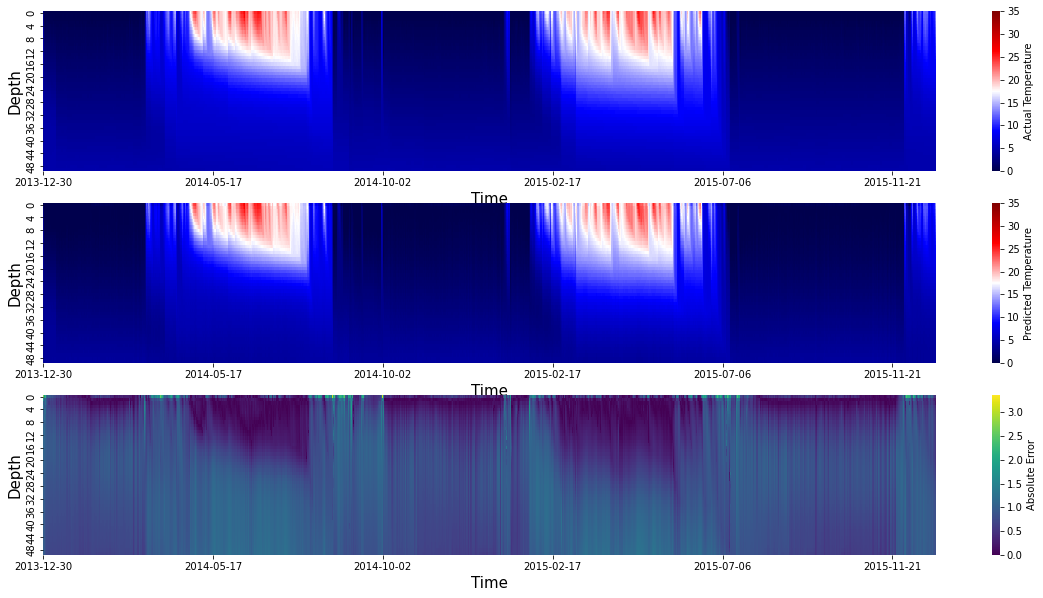

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

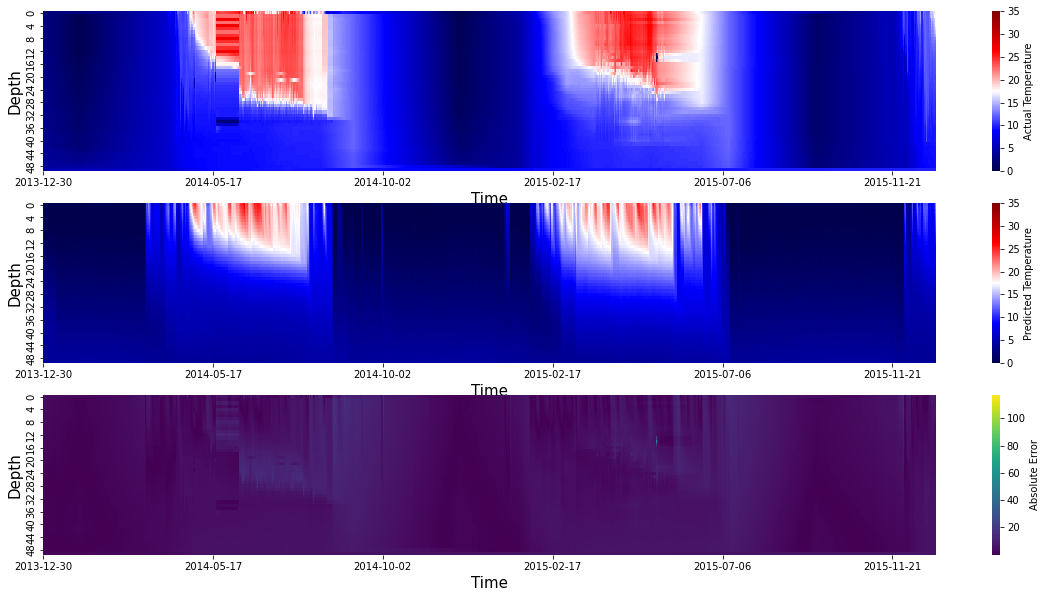

In [24]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [25]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.9067036
RMSE of after m1 0.90674496
RMSE of after m3 0.9046384
RMSE of after m4 0.901065
RMSE of after m0 0.90506667
RMSE of after m1 0.90491164
RMSE of after m3 0.8891108
RMSE of after m4 0.88493294
RMSE of after m0 0.8300249
RMSE of after m1 0.8303506
RMSE of after m3 0.82437426
RMSE of after m4 0.8202778
RMSE of after m0 0.8501018
RMSE of after m1 0.8504858
RMSE of after m3 0.84933984
RMSE of after m4 0.8447206
RMSE of after m0 0.89122975
RMSE of after m1 0.8918667
RMSE of after m3 0.89829755
RMSE of after m4 0.8918024
RMSE of after m0 0.8624376
RMSE of after m1 0.86287147
RMSE of after m3 0.86906314
RMSE of after m4 0.86445105
RMSE of after m0 0.8707704
RMSE of after m1 0.87077343
RMSE of after m3 0.8659616
RMSE of after m4 0.86199224
RMSE of after m0 0.8603464
RMSE of after m1 0.8600118
RMSE of after m3 0.8543474
RMSE of after m4 0.850416
RMSE of after m0 0.89144856
RMSE of after m1 0.89127636
RMSE of after m3 0.88820326
RMSE of after m4 0.88401
RMSE of after m0

RMSE of after m1 0.7218205
RMSE of after m3 0.7172918
RMSE of after m4 0.7135556
RMSE of after m0 0.7324649
RMSE of after m1 0.73319346
RMSE of after m3 0.72785914
RMSE of after m4 0.72224164
RMSE of after m0 0.72324276
RMSE of after m1 0.7240596
RMSE of after m3 0.71859825
RMSE of after m4 0.71348023
RMSE of after m0 0.71270275
RMSE of after m1 0.7136811
RMSE of after m3 0.7085878
RMSE of after m4 0.70381016
RMSE of after m0 0.7221999
RMSE of after m1 0.7229807
RMSE of after m3 0.7184175
RMSE of after m4 0.71356255
RMSE of after m0 0.7200219
RMSE of after m1 0.7206273
RMSE of after m3 0.7161416
RMSE of after m4 0.7115858
RMSE of after m0 0.7534104
RMSE of after m1 0.7541509
RMSE of after m3 0.74922496
RMSE of after m4 0.74417007
RMSE of after m0 0.7592707
RMSE of after m1 0.76004994
RMSE of after m3 0.75591093
RMSE of after m4 0.7509647
RMSE of after m0 0.763329
RMSE of after m1 0.76417845
RMSE of after m3 0.7640983
RMSE of after m4 0.75921637
RMSE of after m0 0.75864863
RMSE of after

RMSE of after m0 1.0869826
RMSE of after m1 1.0897105
RMSE of after m3 1.1014409
RMSE of after m4 1.0949535
RMSE of after m0 1.081773
RMSE of after m1 1.0840974
RMSE of after m3 1.0758264
RMSE of after m4 1.0706279
RMSE of after m0 1.084672
RMSE of after m1 1.0872324
RMSE of after m3 1.0753286
RMSE of after m4 1.0706356
RMSE of after m0 1.0280418
RMSE of after m1 1.0301174
RMSE of after m3 1.0305855
RMSE of after m4 1.0283949
RMSE of after m0 1.0425866
RMSE of after m1 1.0445843
RMSE of after m3 1.0280021
RMSE of after m4 1.0261594
RMSE of after m0 1.0471072
RMSE of after m1 1.0493718
RMSE of after m3 1.0397733
RMSE of after m4 1.0348084
RMSE of after m0 1.0692058
RMSE of after m1 1.0717032
RMSE of after m3 1.0708035
RMSE of after m4 1.0656734
RMSE of after m0 1.1326146
RMSE of after m1 1.137184
RMSE of after m3 1.0135242
RMSE of after m4 1.011356
RMSE of after m0 1.1205647
RMSE of after m1 1.119763
RMSE of after m3 1.0611626
RMSE of after m4 1.0563071
RMSE of after m0 1.1101832
RMSE o

RMSE of after m3 0.6971968
RMSE of after m4 0.68841624
RMSE of after m0 1.2700855
RMSE of after m1 0.94463587
RMSE of after m3 0.7274744
RMSE of after m4 0.7180988
RMSE of after m0 1.3637546
RMSE of after m1 1.0093799
RMSE of after m3 0.69753134
RMSE of after m4 0.6875002
RMSE of after m0 1.4070048
RMSE of after m1 1.0122951
RMSE of after m3 0.70663923
RMSE of after m4 0.69642574
RMSE of after m0 1.3632952
RMSE of after m1 0.98818934
RMSE of after m3 0.7248328
RMSE of after m4 0.71607995
RMSE of after m0 1.3434044
RMSE of after m1 1.0138625
RMSE of after m3 0.65919745
RMSE of after m4 0.65057164
RMSE of after m0 1.2946972
RMSE of after m1 0.9907971
RMSE of after m3 0.67733866
RMSE of after m4 0.6685778
RMSE of after m0 1.2561374
RMSE of after m1 0.9772551
RMSE of after m3 0.72835624
RMSE of after m4 0.7182925
RMSE of after m0 1.2606488
RMSE of after m1 0.98490244
RMSE of after m3 0.71863544
RMSE of after m4 0.7084657
RMSE of after m0 1.2563195
RMSE of after m1 0.97764623
RMSE of after 

RMSE of after m0 1.1613867
RMSE of after m1 0.92554885
RMSE of after m3 0.73264223
RMSE of after m4 0.7074284
RMSE of after m0 1.1190372
RMSE of after m1 0.8893427
RMSE of after m3 0.7878172
RMSE of after m4 0.7604436
RMSE of after m0 1.1113092
RMSE of after m1 0.898682
RMSE of after m3 0.7746235
RMSE of after m4 0.7486577
RMSE of after m0 1.0957124
RMSE of after m1 0.9161855
RMSE of after m3 0.74850506
RMSE of after m4 0.7246503
RMSE of after m0 1.1028583
RMSE of after m1 0.9000156
RMSE of after m3 0.7403534
RMSE of after m4 0.7129832
RMSE of after m0 1.1284673
RMSE of after m1 0.923792
RMSE of after m3 0.8576732
RMSE of after m4 0.8258265
RMSE of after m0 1.1125292
RMSE of after m1 0.9141573
RMSE of after m3 0.83162487
RMSE of after m4 0.8011458
RMSE of after m0 1.0887026
RMSE of after m1 0.888179
RMSE of after m3 0.8096854
RMSE of after m4 0.7782093
RMSE of after m0 1.103727
RMSE of after m1 0.9194666
RMSE of after m3 0.85613865
RMSE of after m4 0.82467484
RMSE of after m0 1.107035


RMSE of after m1 0.8668038
RMSE of after m3 0.8638522
RMSE of after m4 0.8586175
RMSE of after m0 0.874447
RMSE of after m1 0.87447035
RMSE of after m3 0.87253684
RMSE of after m4 0.86710596
RMSE of after m0 0.8388484
RMSE of after m1 0.83898985
RMSE of after m3 0.834334
RMSE of after m4 0.8294627
RMSE of after m0 0.87802833
RMSE of after m1 0.87824297
RMSE of after m3 0.8730226
RMSE of after m4 0.8678711
RMSE of after m0 0.8463152
RMSE of after m1 0.8465817
RMSE of after m3 0.84356195
RMSE of after m4 0.8386044
RMSE of after m0 0.8268108
RMSE of after m1 0.82713133
RMSE of after m3 0.82343936
RMSE of after m4 0.81852
RMSE of after m0 0.8238835
RMSE of after m1 0.8235347
RMSE of after m3 0.8204314
RMSE of after m4 0.81573445
RMSE of after m0 0.8616136
RMSE of after m1 0.8614177
RMSE of after m3 0.85845584
RMSE of after m4 0.8537134
RMSE of after m0 0.88716745
RMSE of after m1 0.8871699
RMSE of after m3 0.88058424
RMSE of after m4 0.8756766
RMSE of after m0 0.8795244
RMSE of after m1 0.

RMSE of after m4 0.81146765
RMSE of after m0 0.774954
RMSE of after m1 0.7757094
RMSE of after m3 0.76868844
RMSE of after m4 0.762608
RMSE of after m0 0.77076954
RMSE of after m1 0.77163744
RMSE of after m3 0.76436126
RMSE of after m4 0.7586134
RMSE of after m0 0.7632207
RMSE of after m1 0.76339346
RMSE of after m3 0.75928384
RMSE of after m4 0.7536657
RMSE of after m0 0.7765936
RMSE of after m1 0.7769007
RMSE of after m3 0.77186155
RMSE of after m4 0.76686496
RMSE of after m0 0.8334032
RMSE of after m1 0.8337957
RMSE of after m3 0.8262316
RMSE of after m4 0.821964
RMSE of after m0 0.8275518
RMSE of after m1 0.8280485
RMSE of after m3 0.8209265
RMSE of after m4 0.8163789
RMSE of after m0 0.82802856
RMSE of after m1 0.8286337
RMSE of after m3 0.82140195
RMSE of after m4 0.8167919
RMSE of after m0 0.7676869
RMSE of after m1 0.7684434
RMSE of after m3 0.7625148
RMSE of after m4 0.7579956
RMSE of after m0 0.78655225
RMSE of after m1 0.7870165
RMSE of after m3 0.7784879
RMSE of after m4 0.

RMSE of after m0 1.0267203
RMSE of after m1 1.031336
RMSE of after m3 1.029188
RMSE of after m4 1.0315193
RMSE of after m0 1.0135223
RMSE of after m1 1.0100262
RMSE of after m3 1.0163058
RMSE of after m4 1.0177957
RMSE of after m0 1.0040123
RMSE of after m1 0.9781216
RMSE of after m3 0.9727992
RMSE of after m4 0.9729048
RMSE of after m0 0.965587
RMSE of after m1 0.9709122
RMSE of after m3 1.1370815
RMSE of after m4 1.1321092
RMSE of after m0 1.0252289
RMSE of after m1 1.0281618
RMSE of after m3 1.1240515
RMSE of after m4 1.1201884
RMSE of after m0 1.0684458
RMSE of after m1 1.0726252
RMSE of after m3 1.0781655
RMSE of after m4 1.0735037
RMSE of after m0 1.0548708
RMSE of after m1 1.0583446
RMSE of after m3 1.091211
RMSE of after m4 1.087134
RMSE of after m0 1.0524478
RMSE of after m1 1.0559653
RMSE of after m3 1.0527011
RMSE of after m4 1.04842
RMSE of after m0 1.0269086
RMSE of after m1 1.0308385
RMSE of after m3 1.0331765
RMSE of after m4 1.0298514
RMSE of after m0 1.0219022
RMSE of 

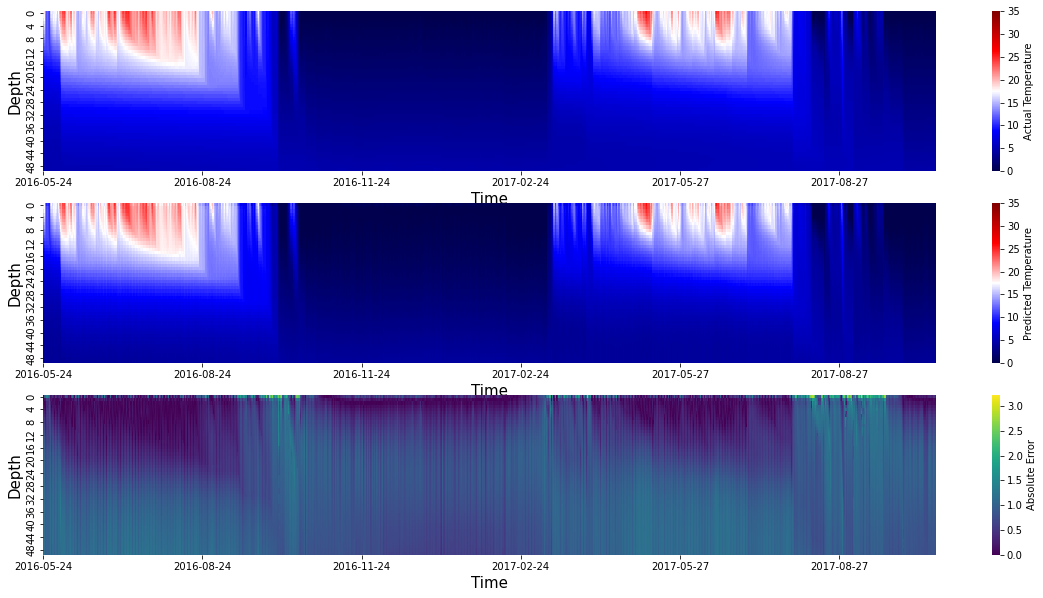

In [26]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

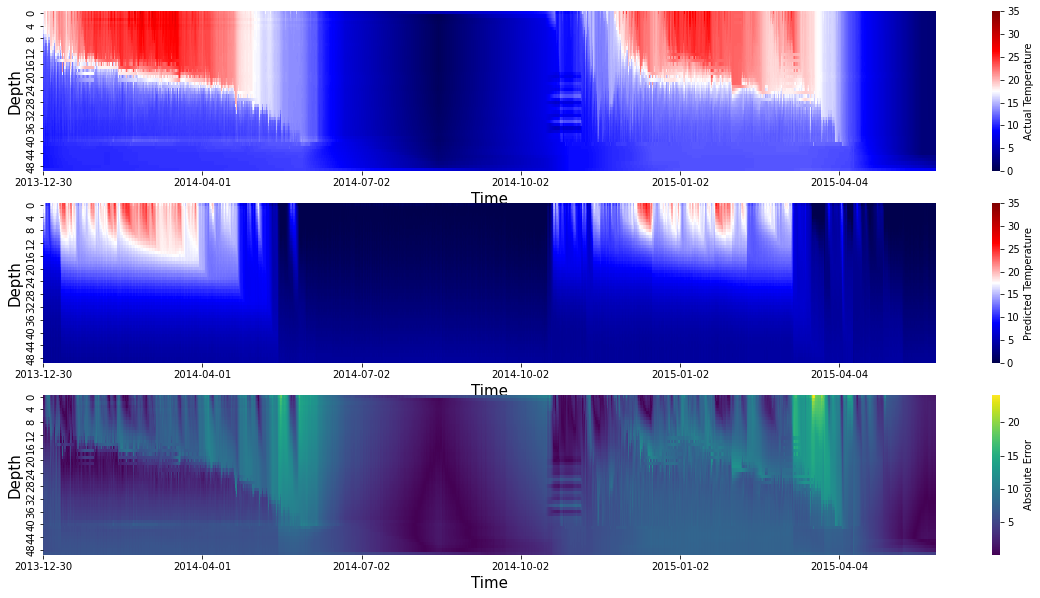

In [27]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [28]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.04008502195523009, Train L2 Error: 0.005229810391001064
Test RMSE: 0.05188066679282778, Train L2 Error: 0.00607248351981356


## Mixing Model

## Convection Model

In [29]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.017907856655414243, Train L2 Error: 0.002336544323501028
Test RMSE: 0.020080285561136977, Train L2 Error: 0.0023504824674516617


## Ice Model

In [30]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.010513074076310984, Train L2 Error: 0.0013708077932798454
Test RMSE: 0.013726233929420852, Train L2 Error: 0.0016056384939331773


# Finetuning

In [31]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [32]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [33]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [34]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out3 = torch.tensor(train_mean[m3_output_column_ix[0]]).float().to(device)
std_out3 = torch.tensor(train_std[m3_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m4_pred = ice_model(m4_input)
        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)

        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out3)/std_out3
        
        loss_m3 = criterion(m3_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m3
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:06<1:55:53,  6.96s/it]

Epoch : 0, Train_loss: 0.955930836737765, Loss m0: 0.043261225351235146, Loss m1: 0.014100046650889,  Loss m3: 0.955930836737765, Loss m4: 0.0328868154698395


  5%|▌         | 51/1000 [05:40<1:45:36,  6.68s/it]

Epoch : 50, Train_loss: 0.15748670589019007, Loss m0: 0.043261225351235146, Loss m1: 0.6673654489707868,  Loss m3: 0.15748670589019007, Loss m4: 0.0328868154698395


 10%|█         | 101/1000 [11:12<1:38:47,  6.59s/it]

Epoch : 100, Train_loss: 0.14218106304710118, Loss m0: 0.043261225351235146, Loss m1: 0.6950905005157192,  Loss m3: 0.14218106304710118, Loss m4: 0.0328868154698395


 15%|█▌        | 151/1000 [16:44<1:33:46,  6.63s/it]

Epoch : 150, Train_loss: 0.13575433747189566, Loss m0: 0.043261225351235146, Loss m1: 0.7043085337524433,  Loss m3: 0.13575433747189566, Loss m4: 0.0328868154698395


 20%|██        | 201/1000 [22:17<1:28:10,  6.62s/it]

Epoch : 200, Train_loss: 0.1303975070909041, Loss m0: 0.043261225351235146, Loss m1: 0.7097901587601142,  Loss m3: 0.1303975070909041, Loss m4: 0.0328868154698395


 25%|██▌       | 251/1000 [27:49<1:23:02,  6.65s/it]

Epoch : 250, Train_loss: 0.12506049380331397, Loss m0: 0.043261225351235146, Loss m1: 0.7137243062640211,  Loss m3: 0.12506049380331397, Loss m4: 0.0328868154698395


 30%|███       | 301/1000 [33:23<1:17:36,  6.66s/it]

Epoch : 300, Train_loss: 0.11993367830667638, Loss m0: 0.043261225351235146, Loss m1: 0.7169596237774952,  Loss m3: 0.11993367830667638, Loss m4: 0.0328868154698395


 35%|███▌      | 351/1000 [38:55<1:11:40,  6.63s/it]

Epoch : 350, Train_loss: 0.11516524988165508, Loss m0: 0.043261225351235146, Loss m1: 0.7199771050824129,  Loss m3: 0.11516524988165508, Loss m4: 0.0328868154698395


 40%|████      | 401/1000 [44:27<1:06:31,  6.66s/it]

Epoch : 400, Train_loss: 0.11066425709184896, Loss m0: 0.043261225351235146, Loss m1: 0.7228662866192512,  Loss m3: 0.11066425709184896, Loss m4: 0.0328868154698395


 45%|████▌     | 451/1000 [50:00<1:01:25,  6.71s/it]

Epoch : 450, Train_loss: 0.10646536859029465, Loss m0: 0.043261225351235146, Loss m1: 0.7258143508629767,  Loss m3: 0.10646536859029465, Loss m4: 0.0328868154698395


 50%|█████     | 501/1000 [55:33<55:21,  6.66s/it]  

Epoch : 500, Train_loss: 0.10263022649949133, Loss m0: 0.043261225351235146, Loss m1: 0.7289389084560705,  Loss m3: 0.10263022649949133, Loss m4: 0.0328868154698395


 55%|█████▌    | 551/1000 [1:01:05<49:37,  6.63s/it]

Epoch : 550, Train_loss: 0.09917211359939555, Loss m0: 0.043261225351235146, Loss m1: 0.7321847990799709,  Loss m3: 0.09917211359939555, Loss m4: 0.0328868154698395


 60%|██████    | 601/1000 [1:06:38<44:05,  6.63s/it]

Epoch : 600, Train_loss: 0.0960643362568624, Loss m0: 0.043261225351235146, Loss m1: 0.7354413187166697,  Loss m3: 0.0960643362568624, Loss m4: 0.0328868154698395


 65%|██████▌   | 651/1000 [1:12:11<39:04,  6.72s/it]

Epoch : 650, Train_loss: 0.09327052623571779, Loss m0: 0.043261225351235146, Loss m1: 0.7386228070689982,  Loss m3: 0.09327052623571779, Loss m4: 0.0328868154698395


 70%|███████   | 701/1000 [1:17:44<33:07,  6.65s/it]

Epoch : 700, Train_loss: 0.09075881712764551, Loss m0: 0.043261225351235146, Loss m1: 0.741680305504272,  Loss m3: 0.09075881712764551, Loss m4: 0.0328868154698395


 75%|███████▌  | 751/1000 [1:23:18<27:33,  6.64s/it]

Epoch : 750, Train_loss: 0.08849916016676786, Loss m0: 0.043261225351235146, Loss m1: 0.7445842531605309,  Loss m3: 0.08849916016676786, Loss m4: 0.0328868154698395


 80%|████████  | 801/1000 [1:28:50<22:05,  6.66s/it]

Epoch : 800, Train_loss: 0.08645765848870357, Loss m0: 0.043261225351235146, Loss m1: 0.7473167052099432,  Loss m3: 0.08645765848870357, Loss m4: 0.0328868154698395


 85%|████████▌ | 851/1000 [1:34:22<16:32,  6.66s/it]

Epoch : 850, Train_loss: 0.08459838664893082, Loss m0: 0.043261225351235146, Loss m1: 0.7498744847129025,  Loss m3: 0.08459838664893082, Loss m4: 0.0328868154698395


 90%|█████████ | 901/1000 [1:39:55<10:56,  6.63s/it]

Epoch : 900, Train_loss: 0.08288808315509874, Loss m0: 0.043261225351235146, Loss m1: 0.752252066684993,  Loss m3: 0.08288808315509874, Loss m4: 0.0328868154698395


 95%|█████████▌| 951/1000 [1:45:28<05:27,  6.67s/it]

Epoch : 950, Train_loss: 0.0813016318273465, Loss m0: 0.043261225351235146, Loss m1: 0.7544611041547427,  Loss m3: 0.0813016318273465, Loss m4: 0.0328868154698395


100%|██████████| 1000/1000 [1:50:54<00:00,  6.65s/it]


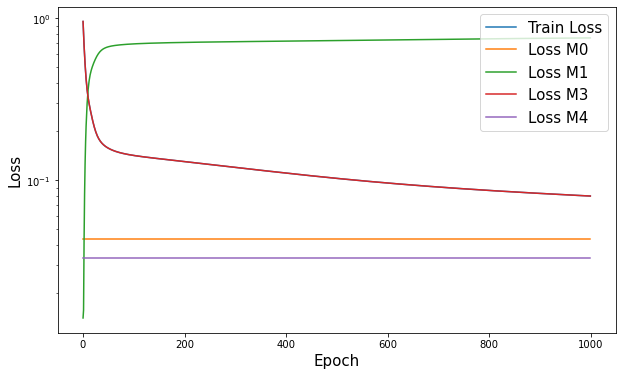

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [36]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 1.0741378
RMSE of after m1 1.0786695
RMSE of after m3 2.8828628
RMSE of after m4 2.887066
RMSE of after m0 1.1212374
RMSE of after m1 1.1282916
RMSE of after m3 3.5448282
RMSE of after m4 3.549778
RMSE of after m0 1.0410389
RMSE of after m1 1.0453647
RMSE of after m3 2.899397
RMSE of after m4 2.9061637
RMSE of after m0 0.97189283
RMSE of after m1 0.9162552
RMSE of after m3 1.6536014
RMSE of after m4 1.6577113
RMSE of after m0 0.97167057
RMSE of after m1 0.8546222
RMSE of after m3 1.3677423
RMSE of after m4 1.3664597
RMSE of after m0 0.9793272
RMSE of after m1 0.85550714
RMSE of after m3 1.301878
RMSE of after m4 1.3004044
RMSE of after m0 0.981682
RMSE of after m1 0.8496642
RMSE of after m3 1.2123984
RMSE of after m4 1.210731
RMSE of after m0 0.98019946
RMSE of after m1 0.84566945
RMSE of after m3 1.1588582
RMSE of after m4 1.1570429
RMSE of after m0 0.9808747
RMSE of after m1 0.8489029
RMSE of after m3 1.1568326
RMSE of after m4 1.154684
RMSE of after m0 0.9802625
RMS

RMSE of after m1 0.91917336
RMSE of after m3 1.3782752
RMSE of after m4 1.4123343
RMSE of after m0 1.1893656
RMSE of after m1 0.8985243
RMSE of after m3 1.4158002
RMSE of after m4 1.4482738
RMSE of after m0 1.1408919
RMSE of after m1 0.87766266
RMSE of after m3 1.512086
RMSE of after m4 1.5467674
RMSE of after m0 1.1666178
RMSE of after m1 0.90803534
RMSE of after m3 1.4391656
RMSE of after m4 1.4732361
RMSE of after m0 1.1474738
RMSE of after m1 0.88394904
RMSE of after m3 1.5370207
RMSE of after m4 1.5706856
RMSE of after m0 1.1590643
RMSE of after m1 0.8834053
RMSE of after m3 1.5600302
RMSE of after m4 1.597168
RMSE of after m0 1.1656383
RMSE of after m1 0.89536774
RMSE of after m3 1.5500833
RMSE of after m4 1.5865856
RMSE of after m0 1.1686491
RMSE of after m1 0.9101763
RMSE of after m3 1.5263498
RMSE of after m4 1.5615859
RMSE of after m0 1.1765989
RMSE of after m1 0.9054617
RMSE of after m3 1.5283129
RMSE of after m4 1.5613604
RMSE of after m0 1.1695466
RMSE of after m1 0.896759

RMSE of after m1 0.8083386
RMSE of after m3 2.887448
RMSE of after m4 2.8898804
RMSE of after m0 0.84367114
RMSE of after m1 0.8448155
RMSE of after m3 3.0128424
RMSE of after m4 3.015939
RMSE of after m0 0.86771524
RMSE of after m1 0.86862266
RMSE of after m3 3.0259533
RMSE of after m4 3.0281641
RMSE of after m0 0.8741031
RMSE of after m1 0.8748102
RMSE of after m3 2.7892401
RMSE of after m4 2.7889974
RMSE of after m0 0.9269132
RMSE of after m1 0.927762
RMSE of after m3 2.6838098
RMSE of after m4 2.682609
RMSE of after m0 0.91765916
RMSE of after m1 0.91813034
RMSE of after m3 2.7123358
RMSE of after m4 2.7105021
RMSE of after m0 0.9311305
RMSE of after m1 0.9312924
RMSE of after m3 2.8387
RMSE of after m4 2.8363764
RMSE of after m0 0.9618909
RMSE of after m1 0.96205807
RMSE of after m3 2.9515355
RMSE of after m4 2.948483
RMSE of after m0 0.97044003
RMSE of after m1 0.97050023
RMSE of after m3 3.0054433
RMSE of after m4 3.0020294
RMSE of after m0 0.9638997
RMSE of after m1 0.96395975


RMSE of after m1 0.8850891
RMSE of after m3 5.7910843
RMSE of after m4 5.80363
RMSE of after m0 0.8854463
RMSE of after m1 0.8852677
RMSE of after m3 5.8592844
RMSE of after m4 5.8711534
RMSE of after m0 0.90293646
RMSE of after m1 0.90293956
RMSE of after m3 5.841259
RMSE of after m4 5.8526607
RMSE of after m0 0.90811473
RMSE of after m1 0.90824085
RMSE of after m3 5.8530416
RMSE of after m4 5.8643274
RMSE of after m0 0.87582433
RMSE of after m1 0.876101
RMSE of after m3 5.8367853
RMSE of after m4 5.8487267
RMSE of after m0 0.84109163
RMSE of after m1 0.84150636
RMSE of after m3 5.825489
RMSE of after m4 5.8394847
RMSE of after m0 0.8214477
RMSE of after m1 0.8216264
RMSE of after m3 5.875971
RMSE of after m4 5.891785
RMSE of after m0 0.8302258
RMSE of after m1 0.8302531
RMSE of after m3 5.9108057
RMSE of after m4 5.9261665
RMSE of after m0 0.8450839
RMSE of after m1 0.8451847
RMSE of after m3 6.008145
RMSE of after m4 6.0227838
RMSE of after m0 0.8561891
RMSE of after m1 0.8563486
RM

RMSE of after m1 0.91310596
RMSE of after m3 6.213595
RMSE of after m4 6.218565
RMSE of after m0 0.8285039
RMSE of after m1 0.82994527
RMSE of after m3 6.2998424
RMSE of after m4 6.3088546
RMSE of after m0 0.81312865
RMSE of after m1 0.8152288
RMSE of after m3 6.565485
RMSE of after m4 6.576276
RMSE of after m0 0.8204968
RMSE of after m1 0.82283324
RMSE of after m3 6.668242
RMSE of after m4 6.6805553
RMSE of after m0 0.8140814
RMSE of after m1 0.8162141
RMSE of after m3 6.855254
RMSE of after m4 6.864557
RMSE of after m0 0.83481425
RMSE of after m1 0.83604604
RMSE of after m3 6.852497
RMSE of after m4 6.861741
RMSE of after m0 0.83415776
RMSE of after m1 0.835159
RMSE of after m3 6.728725
RMSE of after m4 6.7352943
RMSE of after m0 0.86548495
RMSE of after m1 0.8669902
RMSE of after m3 6.808946
RMSE of after m4 6.816595
RMSE of after m0 0.88258123
RMSE of after m1 0.8840555
RMSE of after m3 6.855326
RMSE of after m4 6.861661
RMSE of after m0 0.99594516
RMSE of after m1 0.9988971
RMSE o

RMSE of after m1 0.9007297
RMSE of after m3 5.2546344
RMSE of after m4 5.4144535
RMSE of after m0 1.1793253
RMSE of after m1 0.8946309
RMSE of after m3 5.257975
RMSE of after m4 5.4144216
RMSE of after m0 1.1822512
RMSE of after m1 0.89396256
RMSE of after m3 5.2091575
RMSE of after m4 5.36115
RMSE of after m0 1.1682432
RMSE of after m1 0.8879289
RMSE of after m3 5.271423
RMSE of after m4 5.42183
RMSE of after m0 1.1846621
RMSE of after m1 0.8873053
RMSE of after m3 5.0949206
RMSE of after m4 5.238188
RMSE of after m0 1.1661638
RMSE of after m1 0.89189196
RMSE of after m3 5.1401496
RMSE of after m4 5.2847834
RMSE of after m0 1.1852324
RMSE of after m1 0.896838
RMSE of after m3 4.993787
RMSE of after m4 5.1384892
RMSE of after m0 1.1967313
RMSE of after m1 0.8951776
RMSE of after m3 4.950233
RMSE of after m4 5.0913568
RMSE of after m0 1.1982734
RMSE of after m1 0.89507806
RMSE of after m3 4.846408
RMSE of after m4 4.9827633
RMSE of after m0 1.1980743
RMSE of after m1 0.8917079
RMSE of a

RMSE of after m1 0.9663445
RMSE of after m3 0.99656504
RMSE of after m4 0.97779
RMSE of after m0 1.3061781
RMSE of after m1 0.9741328
RMSE of after m3 1.0438373
RMSE of after m4 1.022395
RMSE of after m0 1.2738441
RMSE of after m1 0.9550228
RMSE of after m3 0.99277014
RMSE of after m4 0.9723363
RMSE of after m0 1.2537136
RMSE of after m1 0.9563209
RMSE of after m3 1.0547087
RMSE of after m4 1.032723
RMSE of after m0 1.207757
RMSE of after m1 0.9355401
RMSE of after m3 0.92632496
RMSE of after m4 0.91185623
RMSE of after m0 1.2222104
RMSE of after m1 0.9515997
RMSE of after m3 0.9851113
RMSE of after m4 0.9678174
RMSE of after m0 1.237717
RMSE of after m1 0.95836735
RMSE of after m3 1.0861595
RMSE of after m4 1.0653541
RMSE of after m0 1.2259997
RMSE of after m1 0.937551
RMSE of after m3 0.9843091
RMSE of after m4 0.96397614
RMSE of after m0 1.2900034
RMSE of after m1 0.99096245
RMSE of after m3 1.0871103
RMSE of after m4 1.0587685
RMSE of after m0 1.3529851
RMSE of after m1 1.0446168
R

RMSE of after m1 0.8373325
RMSE of after m3 3.5241888
RMSE of after m4 3.539954
RMSE of after m0 0.9851003
RMSE of after m1 0.9384806
RMSE of after m3 3.7150521
RMSE of after m4 3.7236123
RMSE of after m0 1.0197791
RMSE of after m1 1.020993
RMSE of after m3 2.8321748
RMSE of after m4 2.8323207
RMSE of after m0 1.065513
RMSE of after m1 1.0667067
RMSE of after m3 2.888568
RMSE of after m4 2.8885083
RMSE of after m0 1.0441123
RMSE of after m1 1.0457408
RMSE of after m3 2.6048174
RMSE of after m4 2.6052127
RMSE of after m0 1.0411197
RMSE of after m1 1.0427113
RMSE of after m3 2.5949473
RMSE of after m4 2.5950115
RMSE of after m0 0.99564314
RMSE of after m1 0.9974373
RMSE of after m3 2.831774
RMSE of after m4 2.8322885
RMSE of after m0 1.0117261
RMSE of after m1 1.0134246
RMSE of after m3 2.8802164
RMSE of after m4 2.8804908
RMSE of after m0 0.9721952
RMSE of after m1 0.9733944
RMSE of after m3 2.6749759
RMSE of after m4 2.674138
RMSE of after m0 0.997413
RMSE of after m1 0.9983973
RMSE of

RMSE of after m3 3.0203674
RMSE of after m4 3.0220692
RMSE of after m0 0.7995664
RMSE of after m1 0.79998296
RMSE of after m3 2.9822812
RMSE of after m4 2.9832823
RMSE of after m0 0.8044665
RMSE of after m1 0.8050807
RMSE of after m3 3.0323677
RMSE of after m4 3.0355086
RMSE of after m0 0.7392768
RMSE of after m1 0.7400562
RMSE of after m3 3.2870033
RMSE of after m4 3.2933683
RMSE of after m0 0.7068968
RMSE of after m1 0.70771366
RMSE of after m3 3.4684916
RMSE of after m4 3.4747453
RMSE of after m0 0.7000475
RMSE of after m1 0.7003769
RMSE of after m3 3.5926483
RMSE of after m4 3.5992644
RMSE of after m0 0.71685326
RMSE of after m1 0.7173586
RMSE of after m3 3.686443
RMSE of after m4 3.693603
RMSE of after m0 0.7306439
RMSE of after m1 0.7312669
RMSE of after m3 3.9408176
RMSE of after m4 3.9496584
RMSE of after m0 0.73173493
RMSE of after m1 0.73238873
RMSE of after m3 4.170307
RMSE of after m4 4.1786556
RMSE of after m0 0.7205239
RMSE of after m1 0.7210904
RMSE of after m3 3.917778


RMSE of after m1 0.7325517
RMSE of after m3 4.5017395
RMSE of after m4 4.514892
RMSE of after m0 0.7177748
RMSE of after m1 0.7182804
RMSE of after m3 4.6223855
RMSE of after m4 4.635806
RMSE of after m0 0.7158274
RMSE of after m1 0.7163778
RMSE of after m3 4.6644063
RMSE of after m4 4.677653
RMSE of after m0 0.7023516
RMSE of after m1 0.70307565
RMSE of after m3 4.6787496
RMSE of after m4 4.6922913
RMSE of after m0 0.6921439
RMSE of after m1 0.6928791
RMSE of after m3 4.7504253
RMSE of after m4 4.763844
RMSE of after m0 0.7088322
RMSE of after m1 0.70898074
RMSE of after m3 4.706205
RMSE of after m4 4.7211494
RMSE of after m0 0.71513605
RMSE of after m1 0.7154038
RMSE of after m3 4.562552
RMSE of after m4 4.5756536
RMSE of after m0 0.7361299
RMSE of after m1 0.7365266
RMSE of after m3 4.4874845
RMSE of after m4 4.499893
RMSE of after m0 0.74108756
RMSE of after m1 0.741506
RMSE of after m3 4.406311
RMSE of after m4 4.417394
RMSE of after m0 0.7509782
RMSE of after m1 0.75161904
RMSE o

RMSE of after m1 1.1547828
RMSE of after m3 9.771464
RMSE of after m4 9.771537
RMSE of after m0 1.1670119
RMSE of after m1 1.0048832
RMSE of after m3 9.6381645
RMSE of after m4 9.659672
RMSE of after m0 1.1694859
RMSE of after m1 0.95389146
RMSE of after m3 9.284926
RMSE of after m4 9.3120365
RMSE of after m0 1.166431
RMSE of after m1 0.95993143
RMSE of after m3 9.207783
RMSE of after m4 9.234162
RMSE of after m0 1.1638087
RMSE of after m1 0.959568
RMSE of after m3 9.156332
RMSE of after m4 9.181824
RMSE of after m0 1.1447595
RMSE of after m1 0.9532377
RMSE of after m3 9.1307745
RMSE of after m4 9.1547575
RMSE of after m0 1.1564234
RMSE of after m1 0.9900762
RMSE of after m3 9.109537
RMSE of after m4 9.131851
RMSE of after m0 1.1697853
RMSE of after m1 1.1830543
RMSE of after m3 9.204279
RMSE of after m4 9.201342
RMSE of after m0 1.1528548
RMSE of after m1 1.1587784
RMSE of after m3 8.633642
RMSE of after m4 8.633327
RMSE of after m0 1.1190236
RMSE of after m1 1.1231948
RMSE of after m

RMSE of after m0 1.2753094
RMSE of after m1 0.9671024
RMSE of after m3 1.2588139
RMSE of after m4 1.2522199
RMSE of after m0 1.2796031
RMSE of after m1 0.9694422
RMSE of after m3 1.1972474
RMSE of after m4 1.1901282
RMSE of after m0 1.3063997
RMSE of after m1 0.96864647
RMSE of after m3 1.177505
RMSE of after m4 1.1696196
RMSE of after m0 1.2937297
RMSE of after m1 0.982776
RMSE of after m3 1.1553632
RMSE of after m4 1.1481987
RMSE of after m0 1.2375184
RMSE of after m1 0.9741868
RMSE of after m3 1.1285731
RMSE of after m4 1.1212666
RMSE of after m0 1.2433172
RMSE of after m1 0.9650625
RMSE of after m3 1.0918676
RMSE of after m4 1.0837325
RMSE of after m0 1.2317749
RMSE of after m1 0.97628915
RMSE of after m3 1.111369
RMSE of after m4 1.1024942
RMSE of after m0 1.1859351
RMSE of after m1 0.9586715
RMSE of after m3 1.1057543
RMSE of after m4 1.0974787
RMSE of after m0 1.3351928
RMSE of after m1 1.0231026
RMSE of after m3 1.1061724
RMSE of after m4 1.0972228
RMSE of after m0 1.4069173
RM

RMSE of after m4 2.5793295
RMSE of after m0 1.2473973
RMSE of after m1 1.0298256
RMSE of after m3 2.7070322
RMSE of after m4 2.626086
RMSE of after m0 1.2385823
RMSE of after m1 1.0197964
RMSE of after m3 2.6442792
RMSE of after m4 2.567599
RMSE of after m0 1.2892072
RMSE of after m1 1.0685233
RMSE of after m3 2.7434483
RMSE of after m4 2.6624787
RMSE of after m0 1.278859
RMSE of after m1 1.0754486
RMSE of after m3 2.752467
RMSE of after m4 2.667815
RMSE of after m0 1.2844203
RMSE of after m1 1.0724096
RMSE of after m3 2.7287068
RMSE of after m4 2.6459153
RMSE of after m0 1.2530682
RMSE of after m1 1.0259824
RMSE of after m3 2.9002516
RMSE of after m4 2.8024802
RMSE of after m0 1.2446514
RMSE of after m1 1.0262411
RMSE of after m3 2.890909
RMSE of after m4 2.7894754
RMSE of after m0 1.26653
RMSE of after m1 1.0582305
RMSE of after m3 2.9309587
RMSE of after m4 2.8277237
RMSE of after m0 1.2505302
RMSE of after m1 1.0538093
RMSE of after m3 2.9280214
RMSE of after m4 2.8201823
RMSE of a

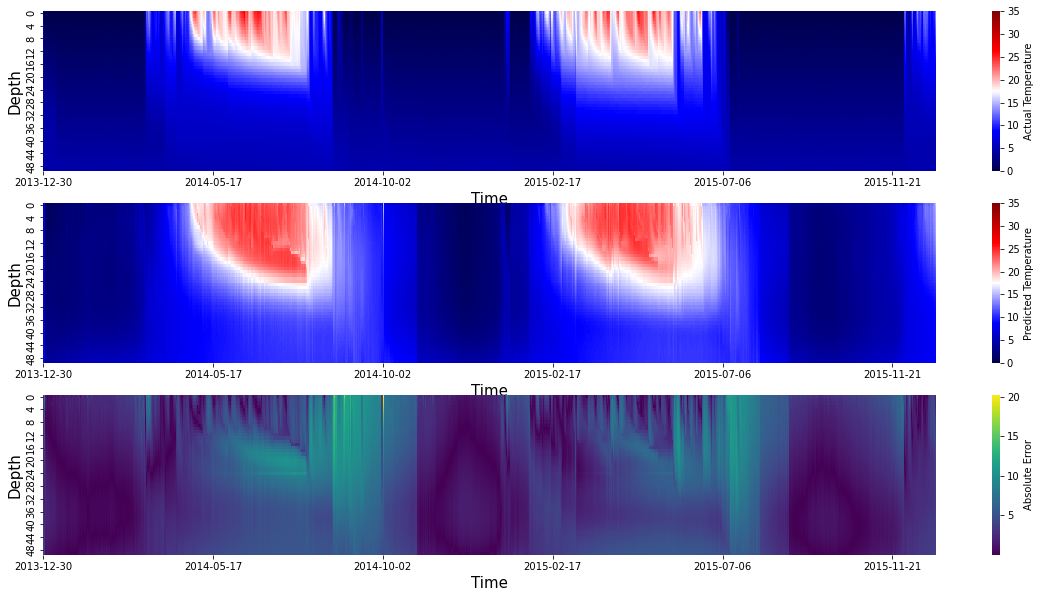

In [37]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

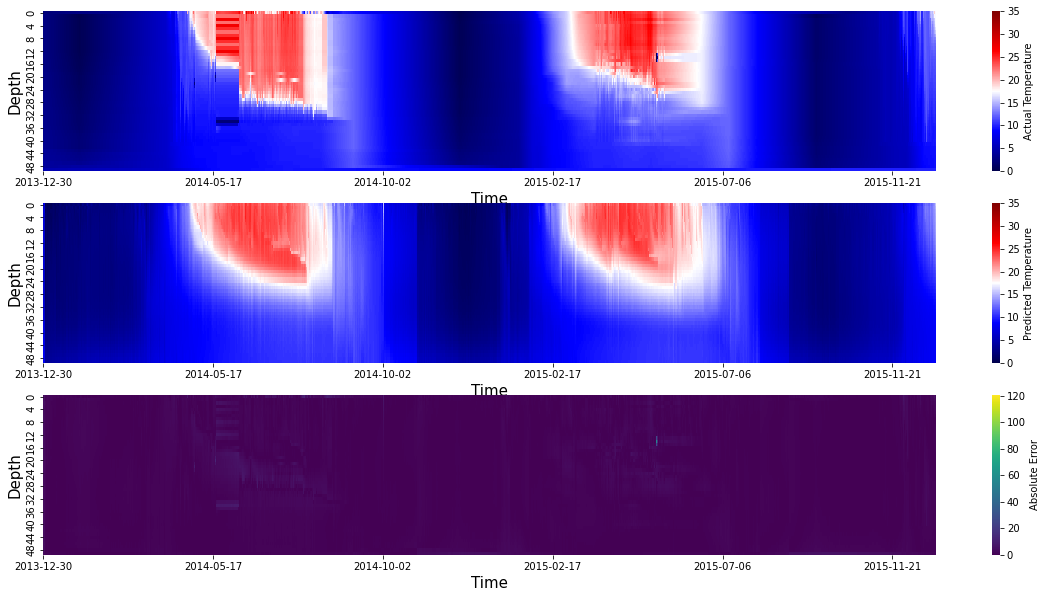

In [38]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [39]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.9067036
RMSE of after m1 0.90674496
RMSE of after m3 2.992757
RMSE of after m4 2.9909706
RMSE of after m0 0.90506667
RMSE of after m1 0.90491164
RMSE of after m3 3.133407
RMSE of after m4 3.1332774
RMSE of after m0 0.8300249
RMSE of after m1 0.8303506
RMSE of after m3 3.3130238
RMSE of after m4 3.316466
RMSE of after m0 0.8501018
RMSE of after m1 0.8504858
RMSE of after m3 3.4229498
RMSE of after m4 3.4268284
RMSE of after m0 0.89122975
RMSE of after m1 0.8918667
RMSE of after m3 3.7479794
RMSE of after m4 3.7518544
RMSE of after m0 0.8624376
RMSE of after m1 0.86287147
RMSE of after m3 3.51978
RMSE of after m4 3.5215738
RMSE of after m0 0.8707704
RMSE of after m1 0.87077343
RMSE of after m3 3.425325
RMSE of after m4 3.4257448
RMSE of after m0 0.8603464
RMSE of after m1 0.8600118
RMSE of after m3 3.2797377
RMSE of after m4 3.2802758
RMSE of after m0 0.89144856
RMSE of after m1 0.89127636
RMSE of after m3 3.3427422
RMSE of after m4 3.3434432
RMSE of after m0 0.9262395

RMSE of after m1 0.7182921
RMSE of after m3 5.25411
RMSE of after m4 5.268716
RMSE of after m0 0.73688114
RMSE of after m1 0.73771256
RMSE of after m3 5.1828647
RMSE of after m4 5.19756
RMSE of after m0 0.73182595
RMSE of after m1 0.7327916
RMSE of after m3 5.095566
RMSE of after m4 5.1108756
RMSE of after m0 0.71031857
RMSE of after m1 0.7111028
RMSE of after m3 5.040628
RMSE of after m4 5.057042
RMSE of after m0 0.70380867
RMSE of after m1 0.7044206
RMSE of after m3 5.1308913
RMSE of after m4 5.1477175
RMSE of after m0 0.72112334
RMSE of after m1 0.7218205
RMSE of after m3 5.265887
RMSE of after m4 5.282773
RMSE of after m0 0.7324649
RMSE of after m1 0.73319346
RMSE of after m3 5.2384977
RMSE of after m4 5.2538457
RMSE of after m0 0.72324276
RMSE of after m1 0.7240596
RMSE of after m3 5.1161532
RMSE of after m4 5.131303
RMSE of after m0 0.71270275
RMSE of after m1 0.7136811
RMSE of after m3 5.045071
RMSE of after m4 5.060666
RMSE of after m0 0.7221999
RMSE of after m1 0.7229807
RMSE 

RMSE of after m1 1.1633605
RMSE of after m3 9.198808
RMSE of after m4 9.199631
RMSE of after m0 1.1316639
RMSE of after m1 1.1349856
RMSE of after m3 8.759186
RMSE of after m4 8.7572
RMSE of after m0 1.1121787
RMSE of after m1 1.1149223
RMSE of after m3 8.0489855
RMSE of after m4 8.045818
RMSE of after m0 1.0869826
RMSE of after m1 1.0897105
RMSE of after m3 7.5886426
RMSE of after m4 7.5865817
RMSE of after m0 1.081773
RMSE of after m1 1.0840974
RMSE of after m3 7.2390985
RMSE of after m4 7.2360916
RMSE of after m0 1.084672
RMSE of after m1 1.0872324
RMSE of after m3 6.96
RMSE of after m4 6.9572387
RMSE of after m0 1.0280418
RMSE of after m1 1.0301174
RMSE of after m3 6.429299
RMSE of after m4 6.426887
RMSE of after m0 1.0425866
RMSE of after m1 1.0445843
RMSE of after m3 6.0595884
RMSE of after m4 6.057449
RMSE of after m0 1.0471072
RMSE of after m1 1.0493718
RMSE of after m3 6.2804027
RMSE of after m4 6.282145
RMSE of after m0 1.0692058
RMSE of after m1 1.0717032
RMSE of after m3 6.

RMSE of after m1 1.0138625
RMSE of after m3 1.0071697
RMSE of after m4 1.0052212
RMSE of after m0 1.2946972
RMSE of after m1 0.9907971
RMSE of after m3 0.98387134
RMSE of after m4 0.9798968
RMSE of after m0 1.2561374
RMSE of after m1 0.9772551
RMSE of after m3 0.9532216
RMSE of after m4 0.94661206
RMSE of after m0 1.2606488
RMSE of after m1 0.98490244
RMSE of after m3 0.96246666
RMSE of after m4 0.95404303
RMSE of after m0 1.2563195
RMSE of after m1 0.97764623
RMSE of after m3 0.95301944
RMSE of after m4 0.94417
RMSE of after m0 1.2588633
RMSE of after m1 0.9800637
RMSE of after m3 0.9537497
RMSE of after m4 0.94606066
RMSE of after m0 1.2456301
RMSE of after m1 0.9760914
RMSE of after m3 0.92178166
RMSE of after m4 0.913049
RMSE of after m0 1.2735044
RMSE of after m1 1.0023661
RMSE of after m3 0.95661885
RMSE of after m4 0.9469615
RMSE of after m0 1.3632199
RMSE of after m1 1.0275527
RMSE of after m3 1.0041978
RMSE of after m4 0.99545646
RMSE of after m0 1.3421786
RMSE of after m1 1.0

RMSE of after m4 2.850702
RMSE of after m0 1.1028583
RMSE of after m1 0.9000156
RMSE of after m3 2.963763
RMSE of after m4 2.8712058
RMSE of after m0 1.1284673
RMSE of after m1 0.923792
RMSE of after m3 3.0345163
RMSE of after m4 2.9332435
RMSE of after m0 1.1125292
RMSE of after m1 0.9141573
RMSE of after m3 3.0660694
RMSE of after m4 2.9609735
RMSE of after m0 1.0887026
RMSE of after m1 0.888179
RMSE of after m3 3.1415985
RMSE of after m4 3.026785
RMSE of after m0 1.103727
RMSE of after m1 0.9194666
RMSE of after m3 3.1490736
RMSE of after m4 3.0293708
RMSE of after m0 1.107035
RMSE of after m1 0.91146874
RMSE of after m3 3.2159586
RMSE of after m4 3.096
RMSE of after m0 1.1156471
RMSE of after m1 0.89698845
RMSE of after m3 3.260022
RMSE of after m4 3.121076
RMSE of after m0 1.091473
RMSE of after m1 0.8749174
RMSE of after m3 3.3339524
RMSE of after m4 3.1939895
RMSE of after m0 1.0943812
RMSE of after m1 0.8859265
RMSE of after m3 3.3256733
RMSE of after m4 3.1858559
RMSE of after

RMSE of after m1 0.82713133
RMSE of after m3 4.050237
RMSE of after m4 4.0533347
RMSE of after m0 0.8238835
RMSE of after m1 0.8235347
RMSE of after m3 4.135685
RMSE of after m4 4.139166
RMSE of after m0 0.8616136
RMSE of after m1 0.8614177
RMSE of after m3 4.314218
RMSE of after m4 4.3185654
RMSE of after m0 0.88716745
RMSE of after m1 0.8871699
RMSE of after m3 4.2680545
RMSE of after m4 4.2715025
RMSE of after m0 0.8795244
RMSE of after m1 0.8795449
RMSE of after m3 4.269236
RMSE of after m4 4.2726493
RMSE of after m0 0.8848181
RMSE of after m1 0.88476264
RMSE of after m3 4.2991514
RMSE of after m4 4.3019648
RMSE of after m0 0.9343325
RMSE of after m1 0.93434393
RMSE of after m3 4.2753572
RMSE of after m4 4.277443
RMSE of after m0 0.9002926
RMSE of after m1 0.8996818
RMSE of after m3 4.216714
RMSE of after m4 4.2188454
RMSE of after m0 0.9232597
RMSE of after m1 0.9228062
RMSE of after m3 4.1440415
RMSE of after m4 4.1461678
RMSE of after m0 0.9478087
RMSE of after m1 0.9474261
RMSE

RMSE of after m4 6.6925635
RMSE of after m0 0.7704108
RMSE of after m1 0.7717878
RMSE of after m3 7.2243233
RMSE of after m4 7.23853
RMSE of after m0 0.7769299
RMSE of after m1 0.77855784
RMSE of after m3 7.149746
RMSE of after m4 7.1631703
RMSE of after m0 0.7786823
RMSE of after m1 0.7804396
RMSE of after m3 7.086281
RMSE of after m4 7.1001253
RMSE of after m0 0.7596449
RMSE of after m1 0.7615694
RMSE of after m3 7.146489
RMSE of after m4 7.159968
RMSE of after m0 0.7559667
RMSE of after m1 0.75805914
RMSE of after m3 7.138252
RMSE of after m4 7.1516075
RMSE of after m0 0.7726977
RMSE of after m1 0.774004
RMSE of after m3 6.9750423
RMSE of after m4 6.9890103
RMSE of after m0 0.7739339
RMSE of after m1 0.7753642
RMSE of after m3 6.7864947
RMSE of after m4 6.7993164
RMSE of after m0 0.786987
RMSE of after m1 0.7885242
RMSE of after m3 6.633236
RMSE of after m4 6.6453958
RMSE of after m0 0.783067
RMSE of after m1 0.78463715
RMSE of after m3 6.5294824
RMSE of after m4 6.541429
RMSE of af

RMSE of after m1 1.121951
RMSE of after m3 6.767628
RMSE of after m4 6.767482
RMSE of after m0 1.0709366
RMSE of after m1 1.07501
RMSE of after m3 6.7553067
RMSE of after m4 6.7553997
RMSE of after m0 1.0635365
RMSE of after m1 1.0673748
RMSE of after m3 6.9564824
RMSE of after m4 6.956019
RMSE of after m0 1.0673229
RMSE of after m1 1.0723765
RMSE of after m3 7.269848
RMSE of after m4 7.2699924
RMSE of after m0 1.1163803
RMSE of after m1 1.1217555
RMSE of after m3 7.6190586
RMSE of after m4 7.619181
RMSE of after m0 1.159028
RMSE of after m1 1.1629031
RMSE of after m3 7.652742
RMSE of after m4 7.6525645
RMSE of after m0 1.1377409
RMSE of after m1 1.1407095
RMSE of after m3 7.3143005
RMSE of after m4 7.3142104
RMSE of after m0 1.1495134
RMSE of after m1 1.1519202
RMSE of after m3 7.1504283
RMSE of after m4 7.1495976
RMSE of after m0 1.1223444
RMSE of after m1 1.1241168
RMSE of after m3 6.9533267
RMSE of after m4 6.9504843
RMSE of after m0 1.110413
RMSE of after m1 1.1127467
RMSE of afte

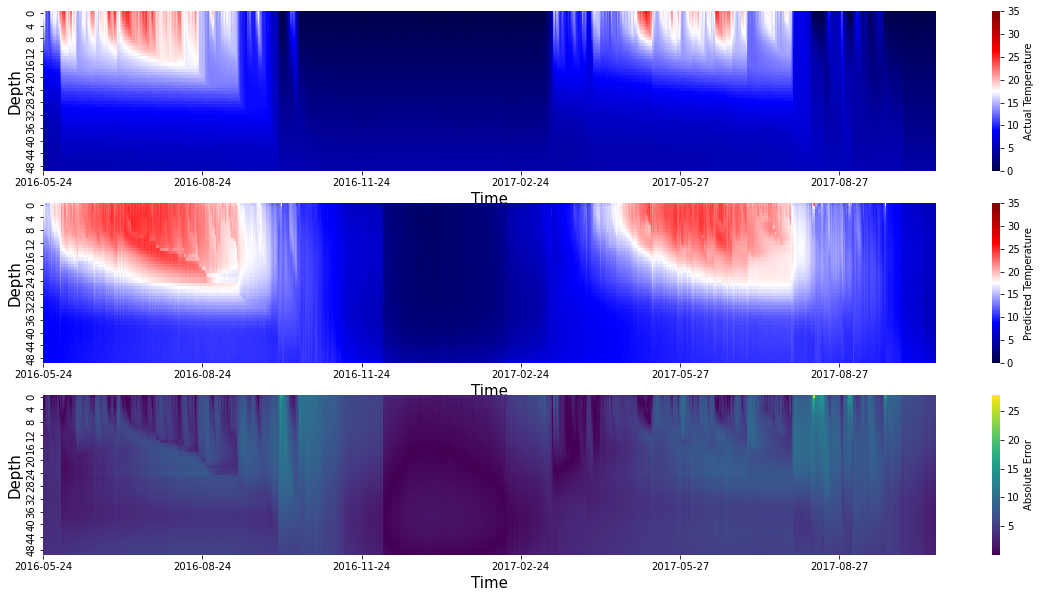

In [40]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

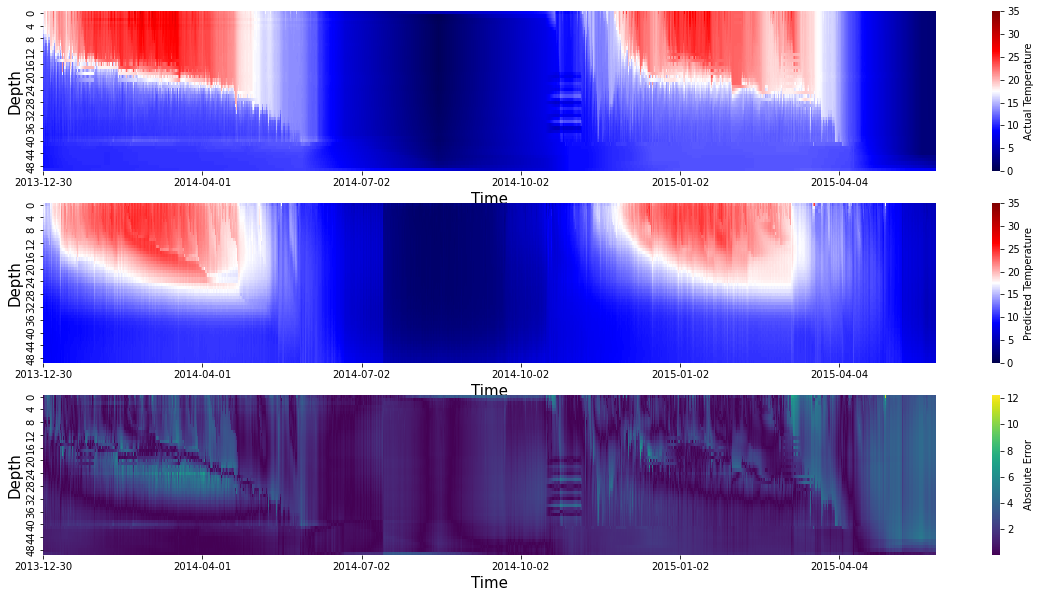

In [41]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [42]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 4.409755054050949, Train L2 Error: 0.5753316744893558
Test RMSE: 5.036145396773963, Train L2 Error: 0.5894664007965794


## Mixing Model

## Convection Model

In [43]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.017907856655414243, Train L2 Error: 0.002336544323501028
Test RMSE: 0.020080285561136977, Train L2 Error: 0.0023504824674516617


## Ice Model

In [44]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.010513074076310984, Train L2 Error: 0.0013708077932798454
Test RMSE: 0.013726233929420852, Train L2 Error: 0.0016056384939331773


# Compute Model Similarity after Finetuning

In [45]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [46]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [47]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.8689454197883606
L2 Norm: 6.1480607986450195


In [48]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [49]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [50]:
# Freeze all models again and compute finetuned diffusivity values

In [51]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [52]:
PATH = f"./saved_models/diffusion_model_finetuned.pth"
torch.save(heat_diff_model.state_dict(), PATH)